# $\chi^2$ Investigations

In this notebook we first investigate how the `absolute_simga` parameter of `curve_fit` can affect the inferred uncertainty on the data.

To this end, we simulate many dataset using a normal distribution:

$$ y\sim \mathcal{N}(\mu, \sigma_y)$$

With $\mu$ the true position as given by our model and $\sigma_y$ the uncertainty (standard error) of the data $y$.

First we define our model:

In [2]:
# basic imports
import scipy.stats
from scipy.optimize import curve_fit
from pylab import * #lazy
import numpy as np

# let's define our model
np.random.seed(10) # fix seed to compare results

# we fix the true values of the parameters
a_true = 2
b_true = 3

# we fix the range of of the independent variable (say, time)
xmin = 0.1
xmax = 10

def linear_model(x, a, b):
	'''
	a line
	'''
	return a + x*b

This function simulates data. We may assume that the uncertainty on $y$ is a fixed fraction of the true value.

In [3]:
def sim_data(x, fractional_uncertainty=0.2):

	# find the model prediction
	y_true = model(x, a_true, b_true)

	# find the true uncertainty on the observations
	y_unc_true = np.abs(y_true)*fractional_uncertainty

	# generate data for a normal distribution
	y_sample = np.random.normal(y_true, y_unc_true, size=len(x))

	return y_sample, y_unc_true


_the cell below allows you to toggle between models (these will be added later)_

In [4]:
# lets pick one model
model = linear_model
#model = non_linear_model # you might add this later



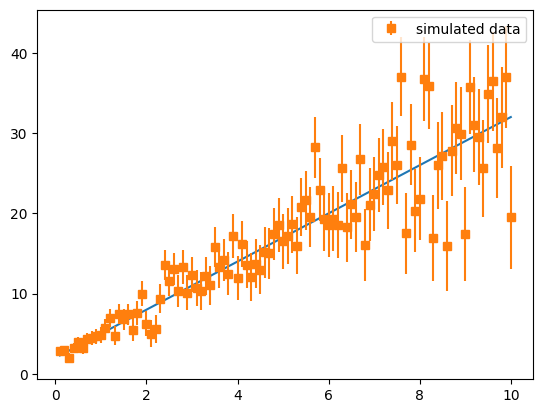

if you think this looks weird, it helps to look in log-space


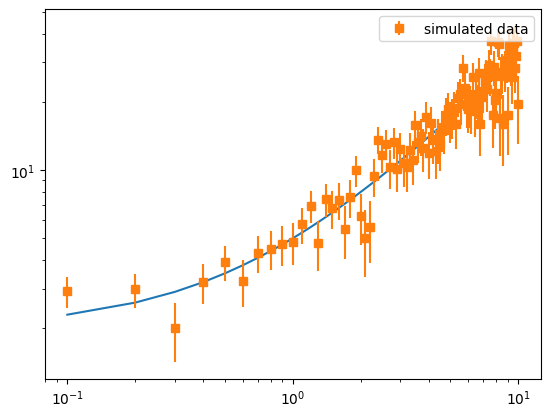

In [5]:
	# plot the simulation results
xx = np.linspace(xmin, xmax, 100)
data_example = sim_data(xx)

plt.clf()
plt.plot(xx, model(xx, a_true, b_true))
plt.errorbar(xx, data_example[0],data_example[1], fmt='s', label='simulated data')
plt.legend()
plt.pause(0.1)
print('if you think this looks weird, it helps to look in log-space')

plt.clf()
plt.plot(xx, model(xx, a_true, b_true))
plt.errorbar(xx, data_example[0],data_example[1], fmt='s', label='simulated data')
plt.legend()
plt.yscale('log')
plt.xscale('log')

## Part 1: $\chi^2$ rescaling of `curve_fit`

Make 5000 simulation of a dataset with N=3 points. Of each simulation, find the standard error on the slope ($\sigma_{b}$) of the best-fit line using `curve_fit` with `absolute_sigma=False` (the default). In this setting the uncertainties are rescaled using the $\chi^2$ of the best-fit parameters.

- Plot a distribution of the 5000 $\chi^2$ and compare to the theoretical value (see `scipy.stats.chi2`).

- Compare the distribution of $\sigma_{b}$ with the "correct" value. How often is confidence interval with $\chi^2$-rescaling a factor 2 larger compared to the correct value?

- Repeat the last step with $N=10$ datapoints.

[array([3.86104477e-01, 4.41561928e-02, 7.03566198e-05]), array([1.33975501e-01, 6.21231575e-04, 1.21444340e-06]), array([5.13653081e-01, 4.72765465e-03, 1.23778462e-04]), array([0.1118703 , 0.00313081, 0.00528614]), array([3.48982685e-01, 9.35233555e-05, 3.90436310e-07]), array([7.51074984e-02, 1.77801721e-03, 7.18525380e-06]), array([4.74781642e-01, 5.89787119e-03, 2.62806900e-06]), array([2.64248637e-01, 7.53551341e-04, 2.04569270e-04]), array([3.19064031e-01, 7.64436904e-04, 6.00231033e-09]), array([3.39015494e-01, 4.91214947e-02, 2.26702749e-08]), array([0.48186259, 0.00129394, 0.00992568]), array([9.95676468e-02, 1.88302749e-04, 5.57250973e-05]), array([0.32452467, 0.00144052, 0.01010049]), array([4.20349047e-01, 3.37907093e-03, 2.26253959e-05]), array([7.21444882e-01, 3.51586586e-03, 6.58547901e-06]), array([2.44054332e-01, 6.42943019e-02, 1.60335153e-05]), array([0.63907338, 0.02486174, 0.00162451]), array([4.35208565e-01, 2.33708275e-03, 3.89421574e-08]), array([2.22812491e-01

TypeError: list indices must be integers or slices, not tuple

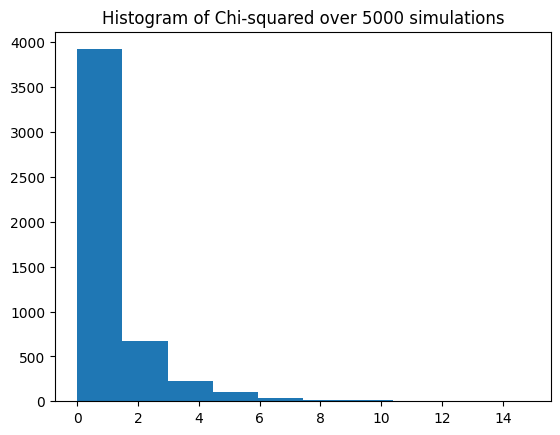

In [23]:
N = 3
simulations = 5000
chis = []
theo_chis = []

x_data = np.linspace(xmin, xmax, N)

for i in range(simulations):

    y_data, y_unc_data = sim_data(x_data)

    popt, pcov = curve_fit(model, x_data, y_data, sigma = y_unc_data, absolute_sigma = False)

    chi = np.sum((y_data - linear_model(x_data, popt[0], popt[1]))**2/ linear_model(x_data, popt[0], popt[1]))
    chis.append(chi)

    vals = scipy.stats.chi2.pdf(x_data, y_data)
    theo_chis.append(vals)


print(theo_chis)

plt.title(f"Histogram of Chi-squared over {simulations} simulations")
plt.hist(chis)
plt.plot(theo_chis[:,0])
plt.xlabel("Chi^2 values")
plt.ylabel("Amount")
plt.show()

In [2]:
print("Hello mars")

Hello mars


## Part 2: Bootstrap and non-linear least-squares

First let's check that bootstrap works for our linear model. Let's do a non-parametric bootstap:

-  simulate _a single_ dataset with $N=400$ points
- Draw $B=20000$ bootstrap samples.
- Compare the bootstrapped distribution of the parameter $b$ with the normal distribution, $\mathcal{N}(0,\sigma_b)$, predicted by the least-squares fit.

You should find good agreement.

The documentation of `curve_fit` says:  
>Note that the relationship between cov and parameter error estimates is derived based on a linear approximation to the model function around the optimum [1]. When this approximation becomes inaccurate, cov may not provide an accurate measure of uncertainty.

But how bad can it be? Let's check. Again we use only two parameters $a$ and $b$.  

We know that the bootstrap will give a more correct answer than least-squares, so we can use this to check the preformance of `curve_fit` confidence intervals.

- dream-up a non-linear model that combines $a$ and $b$, add this above and set `model = non_linear_model`
- Redo comparison of the bootstrap confidence interval with least-squares normal distribution.
 - do you see any difference?
 - Does least-squares aways under/over predict the uncertainty?